<a href="https://colab.research.google.com/github/rahvlrawat/NYCTaxiFare/blob/main/NYC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import Counter
import warnings 
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import lightgbm as lgbm
import xgboost as xgb

# Downloads

In [ ]:
os.system('pip install -q kaggle')
os.system('mkdir ~/.kaggle')
os.system('cp /content/drive/MyDrive/kaggle.json   ~/.kaggle/')
os.system('chmod 600 ~/.kaggle/kaggle.json')



0

In [ ]:
os.system('kaggle competitions download -c new-york-city-taxi-fare-prediction')

0

In [ ]:
os.system('unzip  /content/train.csv.zip')

0

# Exploratory analysis,Cleaning and Feature Engineering

## Preliminary Analysis

First thing we do with a new dataset is to explore the data. This means investigating the number of features, their datatype, their meaning and some basics statistics.

This dataset is huge thus reading all data would require a lot of memory. Therefore I read a limited number of rows while exploring the data.

In [ ]:
train_df =  pd.read_csv('/content/train.csv', nrows = 2_000_000)
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+06,2.000000e+06,2.000000e+06,1.999986e+06,1.999986e+06,2.000000e+06
mean,1.134779e+01,-7.252321e+01,3.992963e+01,-7.252395e+01,3.992808e+01,1.684113e+00
std,9.852883e+00,1.286804e+01,7.983352e+00,1.277497e+01,1.032382e+01,1.314982e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399141e+01,4.073400e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075312e+01,1.000000e+00
75%,1.250000e+01,-7.396713e+01,4.076710e+01,-7.396369e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


Following insights can  be inferred from this small sample of our dataset:


1.   The minimal *fare_amount* is negative. As this does not seem to be realistic I will drop them from the dataset.
2.   Minimum and Maximum *longitude/lattitude coordinates* are way off . Will filter these out using bounding box for co-ordinates of the NYC.
3. Min value for *Passenger count* is 0 thus have to filter these rows where such values exist
4. Mean value for *Passenger count* is  around 1.68 but max value is 200+ which is not quite possible thus will need to see the distribution and filter out the outliers





Now for further insights will try EDA on complete dataset.As data is too big to be read and loaded directly so i used chunk-read   size of 5M along with converting some columns to smaller  datatype  so as  to use less space in memory.

In [ ]:
df_list = [] # list to hold the batch dataframe
chunksize = 5_000_000# 5 million rows at one go. Or try 10 million
traintypes = {'fare_amount': 'float32',
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'pickup_datetime': 'str',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())
for df_chunk in tqdm(pd.read_csv('/content/train.csv', usecols=cols, dtype=traintypes, chunksize=chunksize)):
        df_list.append(df_chunk) 
        del df_chunk
        

train_df = pd.concat(df_list)
del df_list



12it [01:48,  9.07s/it]


There are about total of 55Million+  rows in our dataset.

In [ ]:
len(train_df )

55423856

In [ ]:
train_df.shape

(55423856, 7)

In [ ]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968094,40.768009,-73.956657,40.783764,1


In [ ]:
train_df.isnull().sum().sort_index()/len(train_df)

dropoff_latitude     0.000007
dropoff_longitude    0.000007
fare_amount          0.000000
passenger_count      0.000000
pickup_datetime      0.000000
pickup_latitude      0.000000
pickup_longitude     0.000000
dtype: float64

There are some null values existing in data which we will drop.

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   fare_amount        float32
 1   pickup_datetime    object 
 2   pickup_longitude   float32
 3   pickup_latitude    float32
 4   dropoff_longitude  float32
 5   dropoff_latitude   float32
 6   passenger_count    uint8  
dtypes: float32(5), object(1), uint8(1)
memory usage: 1.5+ GB


In order to utilize the pickup_datetime info will have to break down this data into its basic components year,month,day,hour,minute and seconds later.

In [ ]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,8.077921e+00,-3.875290e+01,1.937328e+01,-3.875261e+01,1.937341e+01,1.685380e+00
std,2.055127e+01,2.556202e+01,1.414234e+01,2.553839e+01,1.412191e+01,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


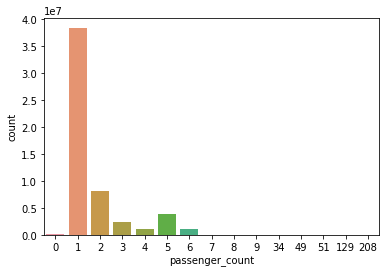

In [ ]:
sns.countplot(x='passenger_count',data=train_df)

From passenger count  plot its deduced that majority of our data lies for 6 passengers which is quite plausible for a cab and thus will drop all data pertaining to passenger count above that.

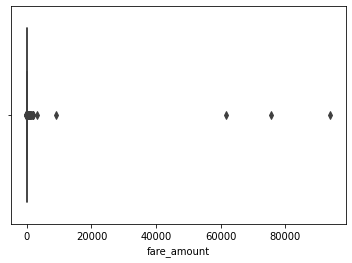

In [ ]:
sns.boxplot(x='fare_amount',data=train_df)

In [ ]:
train_df[train_df["fare_amount"]>20000]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
18859340,61550.859375,2013-08-20 11:52:52 UTC,-73.967712,40.755966,-73.945572,40.747665,1
41032263,93963.359375,2015-02-24 08:57:37 UTC,-73.994461,40.712353,-74.012543,40.702904,2
41186018,75747.023438,2015-05-03 09:35:20 UTC,-73.967949,40.792355,-73.990898,40.738976,1


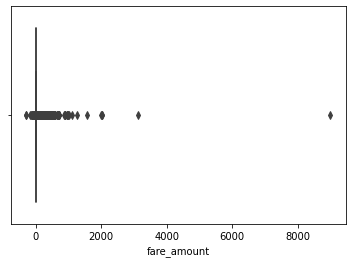

In [ ]:
sns.boxplot(x='fare_amount',data=train_df[train_df["fare_amount"]<20000])

In [ ]:
train_df[train_df["fare_amount"]>2000]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
18592729,2010.900024,2010-03-21 10:03:32 UTC,-73.986267,40.774845,-73.971542,40.743950,1
18859340,61550.859375,2013-08-20 11:52:52 UTC,-73.967712,40.755966,-73.945572,40.747665,1
22703574,3130.300049,2015-03-09 15:28:56 UTC,-74.005417,40.664413,-74.005417,40.664413,1
30823273,2004.500000,2010-03-20 12:24:52 UTC,-73.963135,40.777855,-73.975433,40.782146,1
37879397,2023.699951,2010-03-21 14:43:02 UTC,-73.790054,40.647064,-73.917976,40.656940,1
39374511,9000.410156,2010-02-19 17:10:00 UTC,-73.993744,40.746105,-73.989807,40.738976,1
41032263,93963.359375,2015-02-24 08:57:37 UTC,-73.994461,40.712353,-74.012543,40.702904,2
41186018,75747.023438,2015-05-03 09:35:20 UTC,-73.967949,40.792355,-73.990898,40.738976,1


Will drop these rows with fare > 2000  as fare_amount is too  large for these trips even though there seems to be no irregularity in other data and as can be seen from plots points beyond these are outliers anyways as majority data lies below 2000.

In [ ]:
len(train_df)

55423856

## Feature Engineering

-New York city coordinates are 


longitude = -74.0063889
lattitude = 40.7141667

so accordingly will filter out the coordinates around these.

In [ ]:
jfk = (-73.7781, 40.6413)
ewr = (-74.1745, 40.6895)
lgr = (-73.8740, 40.7769)
tsq =(-74.1745, 40.6895)
met = (-73.9632,40.7794)


Taking a cab around some areas in city  is either quiet expensive than others or the prices are fixed  and thus i have picked up some major Airports/Terminals which are  in the city and cover this scenario.

In [ ]:
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# Returns distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))   # 2*R*asin...

We will use haversine formula in order to calculate distance between the co-ordinates.

In [ ]:
# list to hold the batch dataframe
chunksize = 1_000_000# 5 million rows at one go. Or try 10 million
traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())


In [ ]:
def processed_data(unprocessed_file_path):
  df_list = [] 
  count=0
  for df_chunk in tqdm(pd.read_csv(unprocessed_file_path, usecols=cols, dtype=traintypes, chunksize=chunksize,parse_dates=['pickup_datetime'])):
        df_chunk=df_chunk[df_chunk["fare_amount"].between(1, 2000, inclusive = True) ]
        df_chunk=df_chunk[df_chunk["passenger_count"].between(1, 6, inclusive = True) ]
        
        df_chunk=df_chunk.dropna(how = 'any', axis = 'rows')

        df_chunk=df_chunk[df_chunk['dropoff_longitude'].between(-75,-72, inclusive = True)]
        df_chunk=df_chunk[df_chunk['pickup_longitude'].between(-75, -72, inclusive = True)]
        df_chunk=df_chunk[df_chunk['pickup_latitude'].between(40, 42, inclusive = True)]
        df_chunk=df_chunk[df_chunk['dropoff_latitude'].between(40,42, inclusive = True)]

        df_chunk['diff_lat'] = ( df_chunk['dropoff_latitude'] - df_chunk['pickup_latitude']).abs()
        df_chunk['diff_long'] = (df_chunk['dropoff_longitude'] - df_chunk['pickup_longitude']).abs()

        df_chunk["geodesic"]=df_chunk.apply(lambda x: geopy.distance.geodesic((x.pickup_latitude,x.pickup_longitude),(x.dropoff_latitude,x.dropoff_longitude)), axis=1).astype(str).str[:-3].astype('float32')
        df_chunk=df_chunk[df_chunk["geodesic"]>=1]
        
        df_chunk['pickup_distance_to_jfk'] = distance(jfk[1], jfk[0],df_chunk['pickup_latitude'], df_chunk['pickup_longitude']).astype('float32')
        df_chunk['dropoff_distance_to_jfk'] = distance(jfk[1], jfk[0],df_chunk['dropoff_latitude'], df_chunk['dropoff_longitude']).astype('float32')
        df_chunk['pickup_distance_to_ewr'] = distance(ewr[1], ewr[0],df_chunk['pickup_latitude'], df_chunk['pickup_longitude']).astype('float32')
        df_chunk['dropoff_distance_to_ewr'] = distance(ewr[1], ewr[0],df_chunk['dropoff_latitude'], df_chunk['dropoff_longitude']).astype('float32')
        df_chunk['pickup_distance_to_lgr'] = distance(lgr[1], lgr[0],df_chunk['pickup_latitude'], df_chunk['pickup_longitude']).astype('float32')
        df_chunk['dropoff_distance_to_lgr'] = distance(lgr[1], lgr[0],df_chunk['dropoff_latitude'], df_chunk['dropoff_longitude']).astype('float32')
        df_chunk['pickup_distance_to_tsq'] = distance(tsq[1], tsq[0],df_chunk['pickup_latitude'], df_chunk['pickup_longitude']).astype('float32')
        df_chunk['dropoff_distance_to_tsq'] = distance(tsq[1], tsq[0],df_chunk['dropoff_latitude'], df_chunk['dropoff_longitude']).astype('float32')
        df_chunk['pickup_distance_to_met'] = distance(met[1], met[0],df_chunk['pickup_latitude'], df_chunk['pickup_longitude']).astype('float32')
        df_chunk['dropoff_distance_to_met'] = distance(met[1], met[0],df_chunk['dropoff_latitude'], df_chunk['dropoff_longitude']).astype('float32')

        df_chunk[['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude']]=df_chunk[['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude']].astype('float32')
        
        
        df_chunk['day']=(df_chunk['pickup_datetime'].dt.weekday).astype('uint8')
        df_chunk['month']=(df_chunk['pickup_datetime'].dt.month).astype('uint8')
        df_chunk['year']=df_chunk['pickup_datetime'].dt.year.astype('uint32')
        
        df_chunk['time']=df_chunk['pickup_datetime'].dt.time
        df_chunk[['hh','mm','ss']] = df_chunk['time'].astype(str).str.split(':', expand=True).astype(int)
        df_chunk=df_chunk.drop(["time","pickup_datetime"],axis=1)

        
        df_chunk['hh']=df_chunk['hh'].astype('uint8')
        df_chunk['mm']=df_chunk['mm'].astype('uint8')
        df_chunk['ss']=df_chunk['ss'].astype('uint8')

        
        df_list.append(df_chunk) 
        del df_chunk

        
        if(count==25):
          break
        else:
          count+=1  
        
  
  train_df = pd.concat(df_list)
  del df_list
  return train_df


In [ ]:
train_df = processed_data('train.csv')

25it [3:11:20, 454.78s/it]

First i will remove all duplicates from our data and then  sample this data due to memory limitations and save that sampled data for future use.

In [ ]:
train_df[train_df.duplicated(keep=False)]

In [ ]:
train_df.drop_duplicates(keep=False,inplace=True)

Some duplicate data also exists which we will  filter out.

In [ ]:
train_df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,diff_lat,diff_long,geodesic,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,pickup_distance_to_tsq,dropoff_distance_to_tsq,pickup_distance_to_met,dropoff_distance_to_met,day,month,year,hh,mm,ss
0,4.50,-73.844315,40.721317,-73.841614,40.712276,1,0.009041,0.002701,1.029579,6.527098,5.926695,17.433527,17.507881,4.142829,4.776068,17.433527,17.507881,7.404578,7.875058,0,6,2009,17,26,21
1,16.90,-74.016045,40.711304,-73.979271,40.782005,1,0.070702,0.036774,8.443307,13.373732,14.335908,8.435769,12.054876,8.708064,5.519006,8.435769,12.054876,5.457930,0.859861,1,1,2010,16,52,16
2,5.70,-73.982735,40.761269,-73.991241,40.750561,2,0.010708,0.008507,1.389240,13.550062,13.478043,11.198892,10.482989,5.791427,6.399674,11.198892,10.482989,1.616868,2.474634,3,8,2011,0,35,0
3,7.70,-73.987129,40.733143,-73.991570,40.758091,1,0.024948,0.004440,2.795730,12.657128,13.789624,10.266037,10.687096,6.648248,6.288044,10.266037,10.687096,3.432682,2.090812,5,4,2012,4,30,42
4,5.30,-73.968094,40.768009,-73.956657,40.783764,1,0.015755,0.011436,1.998262,13.254408,13.577181,12.092247,13.133452,4.961637,4.350463,12.092247,13.133452,0.827638,0.456154,1,3,2010,7,51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25999993,5.00,-73.992722,40.737175,-73.993713,40.728092,1,0.009083,0.000992,1.012107,13.050360,12.789841,10.073790,9.837002,6.792769,7.115733,10.073790,9.837002,3.301329,3.888165,6,6,2014,13,32,4
25999995,6.10,-73.990425,40.756519,-74.001434,40.751545,1,0.004974,0.011009,1.081426,13.677677,13.960506,10.693472,10.025496,6.253090,6.895091,10.693472,10.025496,2.128117,2.776214,2,8,2011,13,37,25
25999996,14.50,-73.988182,40.743362,-73.943207,40.717651,1,0.025711,0.044975,4.752609,13.071175,10.132833,10.442926,12.270101,6.409237,5.466407,10.442926,12.270101,2.812328,4.392896,0,11,2011,21,42,31
25999998,14.10,-73.990486,40.758072,-73.996773,40.716457,3,0.041615,0.006287,4.651655,13.742874,12.579947,10.737391,9.493794,6.232863,7.664292,10.737391,9.493794,2.051895,4.690557,6,3,2009,11,51,23


In [ ]:
train_df.to_csv('/content/drive/MyDrive/NYC/mod_traincsv.csv',index=False)
train_df.reset_index().to_feather('/content/drive/MyDrive/NYC/mod_trainfeather.feather')


In [ ]:
print("Done")

Done


##Further processing and inferences

In [ ]:
train_df=pd.read_feather('/content/drive/MyDrive/NYC/mod_trainfeather.feather')


In [ ]:
train_df.set_index("index", inplace = True)

In [ ]:
train_df.shape

(21157353, 25)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21157353 entries, 0 to 25999999
Data columns (total 25 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   fare_amount              float32
 1   pickup_longitude         float32
 2   pickup_latitude          float32
 3   dropoff_longitude        float32
 4   dropoff_latitude         float32
 5   passenger_count          uint8  
 6   diff_lat                 float32
 7   diff_long                float32
 8   geodesic                 float32
 9   pickup_distance_to_jfk   float32
 10  dropoff_distance_to_jfk  float32
 11  pickup_distance_to_ewr   float32
 12  dropoff_distance_to_ewr  float32
 13  pickup_distance_to_lgr   float32
 14  dropoff_distance_to_lgr  float32
 15  pickup_distance_to_tsq   float32
 16  dropoff_distance_to_tsq  float32
 17  pickup_distance_to_met   float32
 18  dropoff_distance_to_met  float32
 19  day                      uint8  
 20  month                    uint8  
 21  year  

In [ ]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,diff_lat,diff_long,geodesic,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,pickup_distance_to_tsq,dropoff_distance_to_tsq,pickup_distance_to_met,dropoff_distance_to_met,day,month,year,hh,mm,ss
count,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07,2.115735e+07
mean,1.237236e+01,-8.129482e+01,4.541893e+01,-8.129440e+01,4.541895e+01,1.692950e+00,2.395914e-02,2.526157e-02,3.635531e+00,1.269591e+01,1.273613e+01,1.271281e+01,1.272190e+01,6.405774e+00,6.411884e+00,1.271281e+01,1.272190e+01,2.629571e+00,2.748460e+00,3.056697e+00,6.282495e+00,2.011750e+03,1.352495e+01,2.956427e+01,1.589732e+01
std,9.318500e+00,7.124118e+00,4.796455e+00,7.124018e+00,4.797296e+00,1.305757e+00,2.410990e-02,3.611553e-02,3.754494e+00,1.947365e+00,1.789110e+00,2.495524e+00,2.457220e+00,1.704177e+00,1.749367e+00,2.495524e+00,2.457220e+00,2.107448e+00,2.140831e+00,1.953589e+00,3.427364e+00,1.862258e+00,6.594528e+00,1.730867e+01,1.944432e+01
min,1.000000e+00,-7.498993e+01,4.000000e+01,-7.499828e+01,4.000000e+01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.506162e-02,2.463167e-03,1.783656e-02,8.233894e-02,2.312567e-02,1.536743e-02,1.783656e-02,8.233894e-02,6.297669e-03,5.016302e-03,0.000000e+00,1.000000e+00,2.009000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.900000e+00,-7.399248e+01,4.073576e+01,-7.399166e+01,4.073459e+01,1.000000e+00,1.019287e-02,8.613586e-03,1.660906e+00,1.276897e+01,1.273697e+01,1.015180e+01,1.023914e+01,5.217282e+00,5.169835e+00,1.015180e+01,1.023914e+01,1.307854e+00,1.343602e+00,1.000000e+00,3.000000e+00,2.010000e+03,9.000000e+00,1.500000e+01,0.000000e+00
50%,9.300000e+00,-7.398216e+01,4.075293e+01,-7.398040e+01,4.075352e+01,1.000000e+00,1.742172e-02,1.550293e-02,2.567379e+00,1.316469e+01,1.315968e+01,1.106450e+01,1.117640e+01,5.993634e+00,5.926847e+00,1.106450e+01,1.117640e+01,2.317429e+00,2.369850e+00,3.000000e+00,6.000000e+00,2.012000e+03,1.400000e+01,3.000000e+01,4.000000e+00
75%,1.370000e+01,-7.396838e+01,4.076766e+01,-7.396462e+01,4.076861e+01,2.000000e+00,3.091431e-02,2.718353e-02,4.448215e+00,1.360486e+01,1.362231e+01,1.209789e+01,1.234011e+01,6.880284e+00,6.860105e+00,1.209789e+01,1.234011e+01,3.605081e+00,3.748127e+00,5.000000e+00,9.000000e+00,2.013000e+03,1.900000e+01,4.500000e+01,3.200000e+01
max,9.520000e+02,-7.200594e+01,4.200000e+01,-7.202303e+01,4.199811e+01,6.000000e+00,1.338558e+00,2.113548e+00,1.953321e+02,1.204819e+02,1.209413e+02,1.327284e+02,1.330920e+02,1.170978e+02,1.174982e+02,1.327284e+02,1.330920e+02,1.203608e+02,1.207409e+02,6.000000e+00,1.200000e+01,2.015000e+03,2.300000e+01,5.900000e+01,5.900000e+01


Text(0, 0.5, 'Latitude')

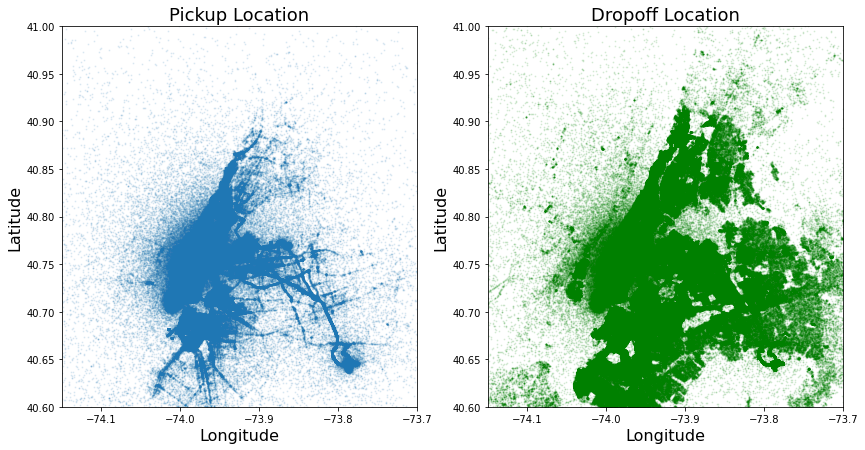

In [ ]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
ax1.scatter(train_df.pickup_longitude,train_df.pickup_latitude,s=1,alpha=0.1)
plt.ylim([40.60,41.00])
plt.xlim([-74.15,-73.70])
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('Pickup Location',fontsize=18)
ax2 = fig.add_subplot(122)
ax2.scatter(train_df.dropoff_longitude,train_df.dropoff_latitude,s=1,color='green',alpha=0.1)
plt.ylim([40.60,41.00])
plt.xlim([-74.15,-73.70])
plt.title('Dropoff Location',fontsize=18)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)

* Pickups are mostly densly populated for around Manhatten 





* Dropoffs are more despersed and are more dense across all regions of NYC

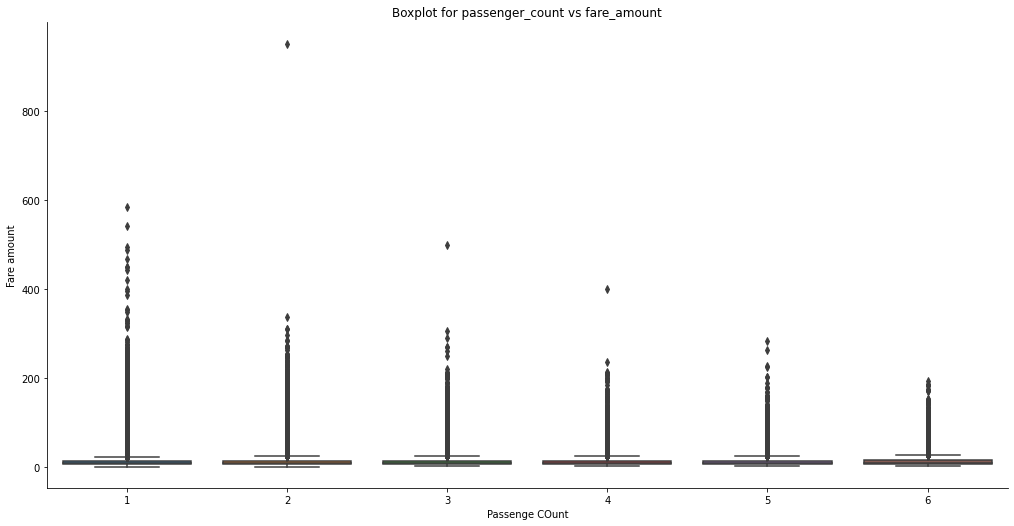

In [ ]:
ax=sns.catplot(data=train_df,x='passenger_count',y='fare_amount',kind='box',height=7,aspect=2)
ax.set(xlabel="Passenge COunt",ylabel="Fare amount",title="Boxplot for passenger_count vs fare_amount")

As indiacated by above  graph   single passengers are the most frequent travellers, and the highest fare also seems to come from cabs which carry just 1 passenger.

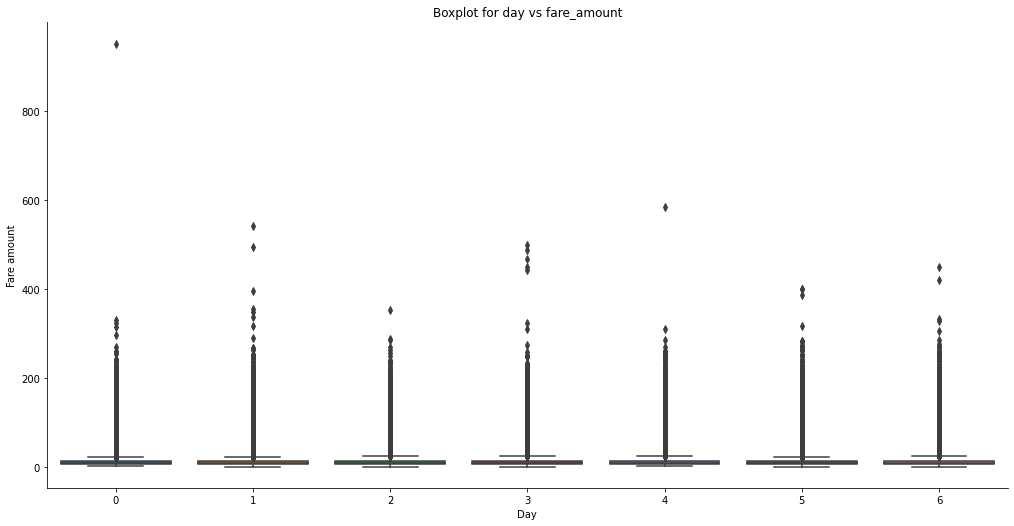

In [ ]:
ax=sns.catplot(data=train_df,x='day',y='fare_amount',kind='box',height=7,aspect=2)
ax.set(xlabel="Day",ylabel="Fare amount",title="Boxplot for day vs fare_amount")

from above graph Fare  is highest on Sunday.

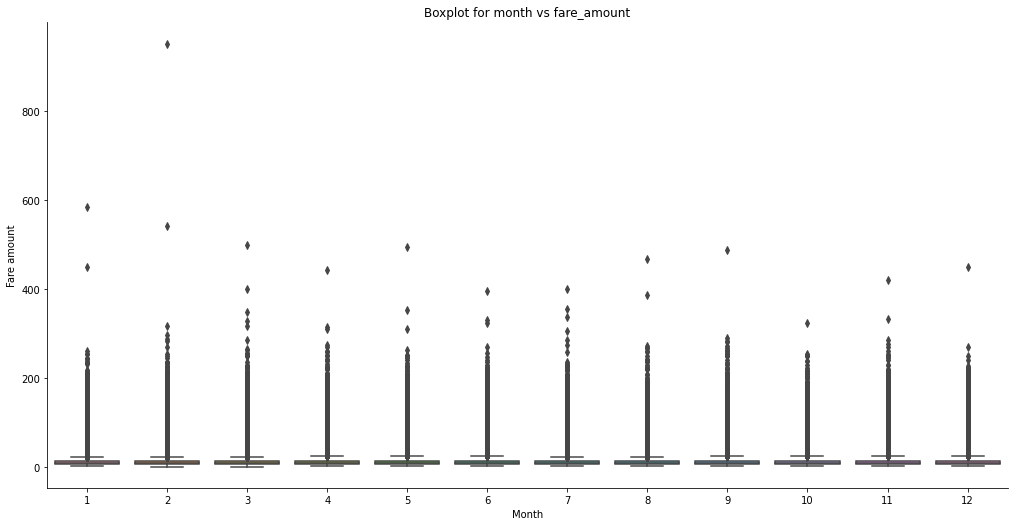

In [ ]:
ax=sns.catplot(data=train_df,x='month',y='fare_amount',kind='box',height=7,aspect=2)
ax.set(xlabel="Month",ylabel="Fare amount",title="Boxplot for month vs fare_amount")

From above graph no particular pattern among these emerges except that gereally recorded fare is charged  quite low for January,October and December as compared to other months and went for highest in February

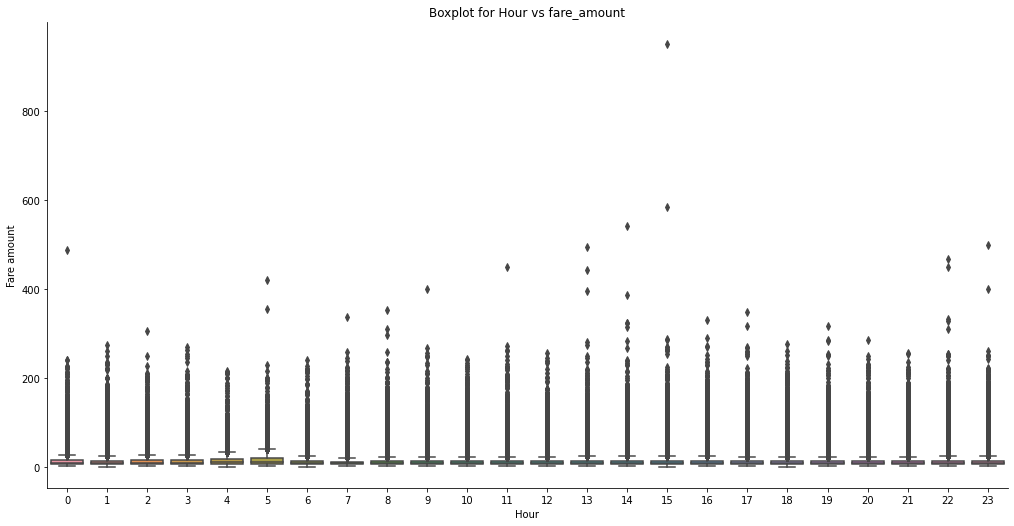

In [ ]:
ax=sns.catplot(data=train_df,x='hh',y='fare_amount',kind='box',height=7,aspect=2)
ax.set(xlabel="Hour",ylabel="Fare amount",title="Boxplot for Hour vs fare_amount")

At certain hours of the day i.e. rush hours the fare charged at instances is higher compared to other times of the day.

In [ ]:
train_df.sort_values(['geodesic','fare_amount'], ascending=False)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,diff_lat,diff_long,geodesic,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,pickup_distance_to_tsq,dropoff_distance_to_tsq,pickup_distance_to_met,dropoff_distance_to_met,day,month,year,hh,mm,ss
index,,,,,,,,,,,,,,,,,,,,,,,,,
17751102,8.5,-72.292488,40.076302,-74.406036,40.773117,2,0.696815,2.113548,195.332123,87.415489,34.126694,107.729042,13.428939,96.239128,27.838921,107.729042,13.428939,100.403580,23.174129,6,6,2010,4,34,0
14229824,8.9,-72.005936,40.137501,-73.975594,40.719059,5,0.581558,1.969658,179.177444,99.543098,11.659762,120.283432,10.616741,107.684731,6.652132,120.283432,10.616741,112.044075,4.219329,4,1,2009,2,32,0
14360243,9.0,-72.146187,40.022034,-73.978790,40.747082,1,0.725048,1.832603,175.200134,96.012314,12.804369,116.322525,10.993978,104.808784,5.858243,116.322525,10.993978,108.985870,2.377357,6,9,2013,17,22,31
9363026,7.5,-73.982201,40.753693,-72.118568,41.438103,1,0.684410,1.863632,174.038223,13.214177,102.517868,11.003263,118.934494,5.884872,102.168045,11.003263,118.934494,2.035568,106.265953,1,2,2014,11,1,0
21586697,6.5,-72.016670,40.720234,-74.009933,40.708832,1,0.011402,1.993263,168.426178,92.453323,13.013694,113.040329,8.723301,97.296700,8.529629,113.040329,8.723301,101.966751,5.455097,2,1,2013,19,58,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11567816,4.5,-73.982506,40.771694,-73.981384,40.780659,3,0.008965,0.001122,1.000000,13.992499,14.354953,11.545690,11.911840,5.688791,5.624347,11.545690,11.911840,1.141855,0.955351,6,3,2013,18,18,16
2086282,4.1,-73.990921,40.746933,-73.990105,40.737949,1,0.008984,0.000816,1.000000,13.325471,12.959855,10.400399,10.220750,6.459685,6.645839,10.400399,10.220750,2.671467,3.191389,2,11,2011,21,52,0
9750184,4.1,-73.976974,40.719360,-73.987900,40.722824,4,0.003464,0.010925,1.000000,11.733563,12.351815,10.549800,10.041138,6.697667,7.035855,10.549800,10.041138,4.210529,4.117260,3,1,2011,10,58,0


In [ ]:
bins_0 = train_df.loc[(train_df['geodesic'] == 0), ['geodesic']]
bins_1 = train_df.loc[(train_df['geodesic'] > 0) & (train_df['geodesic'] <= 10),['geodesic','fare_amount']]
bins_2 = train_df.loc[(train_df['geodesic'] > 10) & (train_df['geodesic'] <= 50),['geodesic','fare_amount']]
bins_3 = train_df.loc[(train_df['geodesic'] > 50) & (train_df['geodesic'] <= 100),['geodesic','fare_amount']]
bins_4 = train_df.loc[(train_df['geodesic'] > 100) & (train_df['geodesic'] <= 200),['geodesic','fare_amount']]
bins_5 = train_df.loc[(train_df['geodesic'] > 200) & (train_df['geodesic'] <= 300),['geodesic','fare_amount']]
bins_6 = train_df.loc[(train_df['geodesic'] > 300),['geodesic']]
bins_0['bins'] = '0'
bins_1['bins'] = '0-10'
bins_2['bins'] = '11-50'
bins_3['bins'] = '51-100'
bins_4['bins'] = '100-200'
bins_5['bins'] = '201-300'
bins_6['bins'] = '>300'
dist_bins =pd.concat([bins_0,bins_1,bins_2,bins_3,bins_4,bins_5,bins_6])
#len(dist_bins)
dist_bins.columns

Index(['geodesic', 'bins', 'fare_amount'], dtype='object')

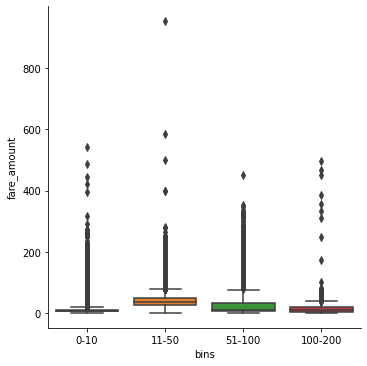

In [ ]:
sns.catplot(data=dist_bins,x='bins',y='fare_amount',kind='box')

Form above plot following observations can be made:
 

*   Even for short distance trips high fare have been charged at times due to unknown underlying reasons which can perhaps be  a consequence of traffic or hour of trip or any other reasons due to which so high fare was charged even for short trip.
*   For some large distance trips against our intuition of bigger fare for longer trips the fare_charged is to a great extent similar to that for short trips i.e. charged amount is too low which may be due to some discount offers etc which have decreased the fare amount to a considerable degree in these instances.


*   In some cases though the fare is unbilievably high it perhaps can be due to reasons such as damage to cab,some sort of fine etc. which were paid along with trip fare as total fare amount.



Text(0, 0.5, 'Frequency')

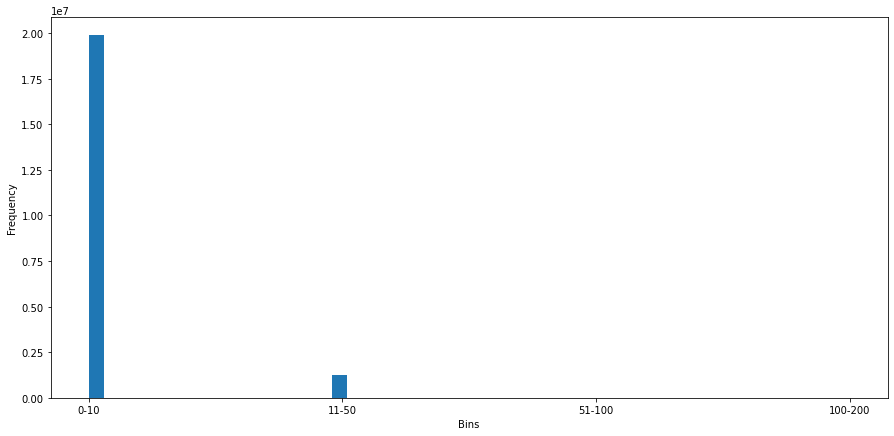

In [ ]:
plt.figure(figsize=(15,7))
plt.hist(dist_bins['bins'], bins=50)
plt.xlabel('Bins')
plt.ylabel('Frequency')

In [ ]:
Counter(dist_bins['bins'])

Counter({'0-10': 19877178, '100-200': 959, '11-50': 1275409, '51-100': 3807})

Majority of trips for of very short distance and freuency of trips grew lesser and lesser with increase in trip distance i.e. lesser trips for large distance are done via the cabs.

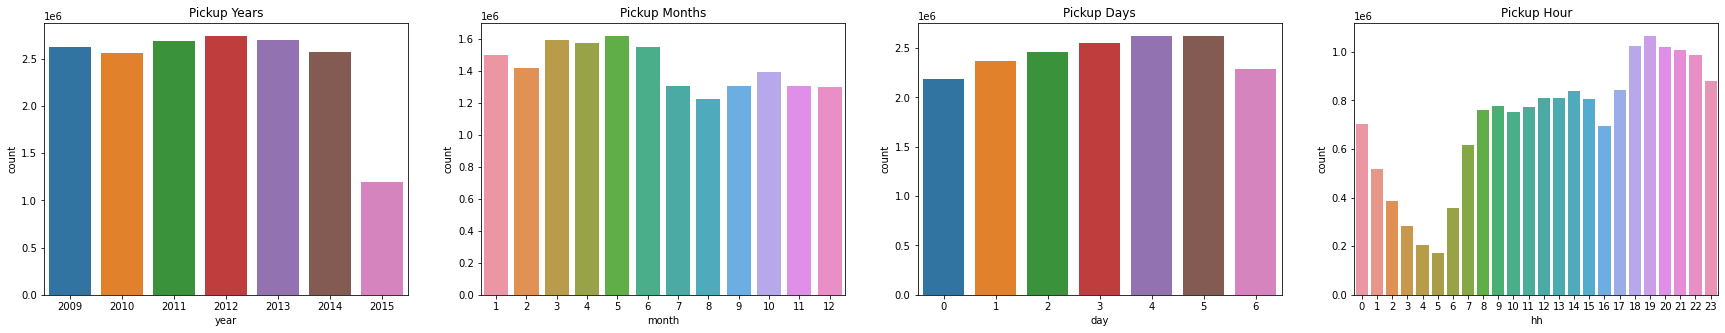

In [ ]:
figure,(ax1,ax2,ax3,ax4)=plt.subplots(ncols=4,figsize=(30,5))
ax1.set_title('Pickup Years')
ax=sns.countplot(x="year",data=train_df,ax=ax1)
ax2.set_title('Pickup Months')
ax=sns.countplot(x="month",data=train_df,ax=ax2)
ax3.set_title('Pickup Days')
ax=sns.countplot(x="day",data=train_df,ax=ax3)
ax4.set_title('Pickup Hour')
ax=sns.countplot(x="hh",data=train_df,ax=ax4)



From above graphs following observations can be made:


1.   Over the year total pickups have more or less remains the same but we can see very low value for year 2015 which is  due to the data not being for the complete year in case of 2015.

2.   As the year progresses the total pickups have gone down a bit month to month basis after initial high of first six months

3. Most pickups are made in weekdays compared to weekends

4. Most pickups are made 6 PM -11 PM 



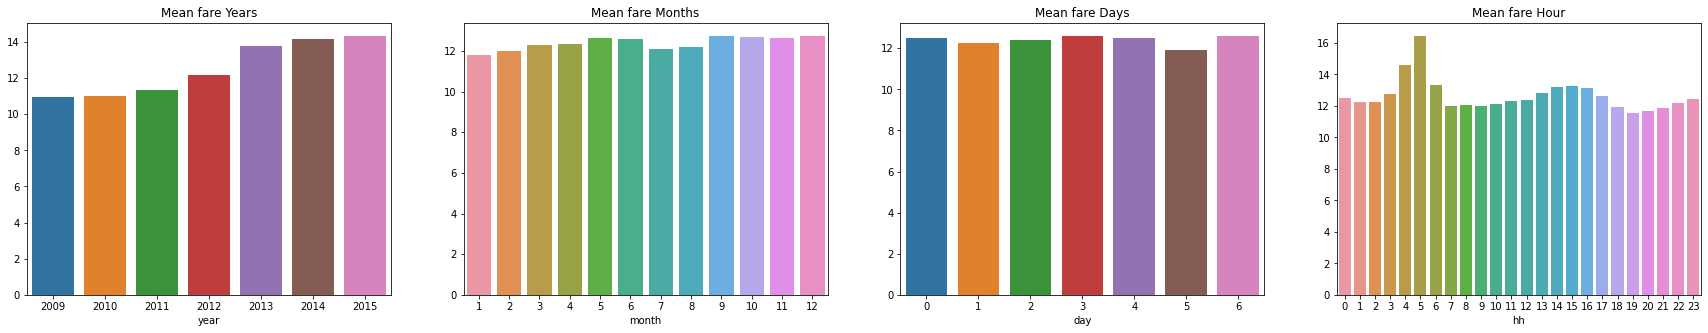

In [ ]:
figure,(ax1,ax2,ax3,ax4)=plt.subplots(ncols=4,figsize=(30,5))
ax1.set_title('Mean fare Years')
fair_yearmean=train_df.groupby('year')["fare_amount"].mean()
ax=sns.barplot(fair_yearmean.index,fair_yearmean.values,ax=ax1)

ax2.set_title('Mean fare Months')
fair_monthmean=train_df.groupby('month')["fare_amount"].mean()
ax=sns.barplot(fair_monthmean.index,fair_monthmean.values,ax=ax2)

ax3.set_title('Mean fare Days')
fair_daymean=train_df.groupby('day')["fare_amount"].mean()
ax=sns.barplot(fair_daymean.index,fair_daymean.values,ax=ax3)

ax4.set_title('Mean fare Hour')
fair_hourmean=train_df.groupby('hh')["fare_amount"].mean()
ax=sns.barplot(fair_hourmean.index,fair_hourmean.values,ax=ax4)



From above graphs following observations can be made:

1.   Over the years mean fare has increased in a progressive manner
2.   Over the months more or less mean fare has remained almost same with little variation for some months here and there
3. Mean fare remains similar for all days of the week with a little variation 
4. Mean fare is high for 4 AM -6 AM as opposed to other hours of the day 




In [ ]:
# train_df.reset_index().to_csv('/content/drive/MyDrive/NYC/mod_traincsv.csv',index=False)

In [ ]:
# train_df.reset_index().to_feather('/content/drive/MyDrive/NYC/mod_trainfeather.feather')

##Training/Validation sets for Baseline,RandomForest and Linear Regression

### Year-wise split

In [ ]:
train_df=pd.read_feather('/content/drive/MyDrive/NYC/mod_trainfeather.feather')
train_df.set_index("index", inplace = True)

In [ ]:
train_df.shape

(21157353, 25)

In [ ]:
#train_df=train_df.sample(10_000_000)
#For some models entire data can't be loaded so we will sample this data

In [ ]:
train=train_df[train_df["year"]<2014]
valid=train_df[train_df["year"]>=2014]

In [ ]:
del train_df

In [ ]:
X_train,y_train= train.drop('fare_amount', axis = 1),train['fare_amount']
X_test,y_test= valid.drop('fare_amount', axis = 1),valid['fare_amount']

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

### Random split

In [2]:
train_df=pd.read_feather('/content/drive/MyDrive/NYC/mod_trainfeather.feather')
train_df.set_index("index", inplace = True)

In [3]:
train_df.shape

(21157353, 25)

In [4]:
train_df=train_df.sample(8_000_000)
#For some models entire data can't be loaded so we will sample this data

In [5]:
X,y= train_df.drop('fare_amount', axis = 1),train_df['fare_amount']

In [6]:
del train_df

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
del X,y

In [9]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((5600000, 24), (2400000, 24), (5600000,), (2400000,))

I will use this train/validation set on different models and will further try to process data based on feature importance  and choose best model for my use case i.e. fare prediction.

#Models

##BaseLine

###Random split

In [ ]:
avg_fare=round(np.mean(y_train),2) #11.31
baseline_pred=np.repeat(avg_fare,y_test.shape[0])
baseline_rmse=np.sqrt(mean_squared_error(baseline_pred, y_test))
print("Basline RMSE of Validation data :",baseline_rmse)

Basline RMSE of Validation data : 9.788066601902926


###Year Split

In [ ]:
avg_fare=round(np.mean(y_train),2) #11.31
baseline_pred=np.repeat(avg_fare,y_test.shape[0])
baseline_rmse=np.sqrt(mean_squared_error(baseline_pred, y_test))
print("Basline RMSE of Validation data :",baseline_rmse)

Basline RMSE of Validation data : 11.609507235608856


### Results 

Baseline RMSE comes out to be quite large.




*   Random split  == 9.788066601902926
*   List item ==11.609507235608856





## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

###Random split

In [ ]:
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred=np.round(lm.predict(X_test),2)
lm_rmse=np.sqrt(mean_squared_error(y_pred, y_test))
lm_train_rmse=np.sqrt(mean_squared_error(lm.predict(X_train), y_train))
lm_variance=abs(lm_train_rmse - lm_rmse)
print("Test RMSE for Linear Regression : ",lm_rmse)
print("Train RMSE for Linear Regression :  ",lm_train_rmse)
print("Variance for Linear Regression is : ",lm_variance)

Test RMSE for Linear Regression :  4.271755416914595
Train RMSE for Linear Regression :   4.286256653179894
Variance for Linear Regression is :  0.014501236265298978


### Year split

In [ ]:
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred=np.round(lm.predict(X_test),2)
lm_rmse=np.sqrt(mean_squared_error(y_pred, y_test))
lm_train_rmse=np.sqrt(mean_squared_error(lm.predict(X_train), y_train))
lm_variance=abs(lm_train_rmse - lm_rmse)
print("Test RMSE for Linear Regression : ",lm_rmse)
print("Train RMSE for Linear Regression :  ",lm_train_rmse)
print("Variance for Linear Regression is : ",lm_variance)

Test RMSE for Linear Regression :  4.810091558532721
Train RMSE for Linear Regression :   4.15621560669996
Variance for Linear Regression is :  0.6538759518327613


###Much better results than Baseline. Let's see if further improvements can be made using other models.

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_estimators =40 , max_samples=200_000,max_features=0.7,min_samples_leaf=5,random_state = 42,n_jobs=-1,oob_score=True)

In [ ]:
rf.fit(X_train,y_train) 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.7, max_leaf_nodes=None,
                      max_samples=200000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
rf_pred= rf.predict(X_test)

### Random split

In [ ]:
rf_rmse=np.sqrt(mean_squared_error(rf_pred, y_test))
print("RMSE for Random Forest is ",rf_rmse)

RMSE for Random Forest is  3.17682276253329


### Year-wise split

In [ ]:
rf_rmse=np.sqrt(mean_squared_error(rf_pred, y_test))
print("RMSE for Random Forest is ",rf_rmse)

RMSE for Random Forest is  3.664561851663333


# LightGBM

In [ ]:
import lightgbm as lgbm

### Random split

In [11]:
train_data=lgbm.Dataset(X_train,label=y_train)
param = {'num_leaves':31, 'num_trees':5000,'objective':'regression'}
param['metric'] = 'l2_root'
num_round=5000
cv_results = lgbm.cv(param, train_data, num_boost_round=num_round, nfold=10,verbose_eval=200, early_stopping_rounds=20,stratified=False)

[200]	cv_agg's rmse: 3.09786 + 0.0650525
[400]	cv_agg's rmse: 3.03851 + 0.0665255
[600]	cv_agg's rmse: 3.01081 + 0.0677023
[800]	cv_agg's rmse: 2.99505 + 0.068316
[1000]	cv_agg's rmse: 2.98422 + 0.0683895
[1200]	cv_agg's rmse: 2.97766 + 0.0685679
[1400]	cv_agg's rmse: 2.97257 + 0.0686855
[1600]	cv_agg's rmse: 2.96846 + 0.0689225
[1800]	cv_agg's rmse: 2.9653 + 0.0692967
[2000]	cv_agg's rmse: 2.9629 + 0.0694609
[2200]	cv_agg's rmse: 2.96048 + 0.0697908
[2400]	cv_agg's rmse: 2.95865 + 0.0699854
[2600]	cv_agg's rmse: 2.95727 + 0.0698782
[2800]	cv_agg's rmse: 2.95601 + 0.0699517
[3000]	cv_agg's rmse: 2.95489 + 0.0700384
[3200]	cv_agg's rmse: 2.95408 + 0.0701946
[3400]	cv_agg's rmse: 2.95335 + 0.0702156
[3600]	cv_agg's rmse: 2.95258 + 0.070133
[3800]	cv_agg's rmse: 2.95196 + 0.0699414


In [12]:
lgbm_bst=lgbm.train(param,train_data,len(cv_results['rmse-mean']))

In [16]:
lgbm_pred = lgbm_bst.predict(X_test)
lgbm_rmse=np.sqrt(mean_squared_error(lgbm_pred, y_test))

In [14]:
print("RMSE for Light GBM is ",lgbm_rmse)

RMSE for Light GBM is  2.924444841889827


In [15]:
print("RMSE for Light GBM is ",lgbm_rmse)

RMSE for Light GBM is  2.924444841889827


In [18]:
filename="/content/drive/MyDrive/NYC/LightGBMrandom.sav"
# to save the model
pickle.dump(lgbm_bst, open(filename, 'wb'))

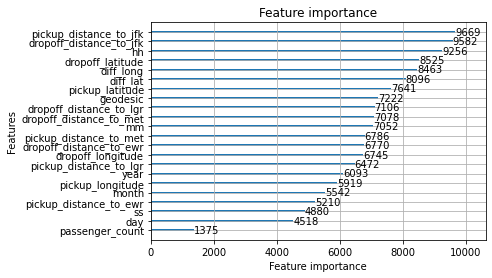

In [19]:
lgbm.plot_importance(lgbm_bst,title='Feature importance', xlabel='Feature importance', ylabel='Features')

### Year split

In [ ]:
train_data=lgbm.Dataset(X_train,label=y_train)
param = {'num_leaves':31, 'num_trees':5000,'objective':'regression'}
param['metric'] = 'l2_root'
num_round=5000
cv_results = lgbm.cv(param, train_data, num_boost_round=num_round, nfold=10,verbose_eval=200, early_stopping_rounds=20,stratified=False)
lgbm_bst=lgbm.train(param,train_data,len(cv_results['rmse-mean']))
lgbm_pred = lgbm_bst.predict(X_test)
lgbm_rmse=np.sqrt(mean_squared_error(lgbm_pred, y_test))

[200]	cv_agg's rmse: 2.9722 + 0.0360383
[400]	cv_agg's rmse: 2.91139 + 0.0369004
[600]	cv_agg's rmse: 2.88422 + 0.0376977
[800]	cv_agg's rmse: 2.86908 + 0.0374322
[1000]	cv_agg's rmse: 2.85988 + 0.0377442
[1200]	cv_agg's rmse: 2.85259 + 0.0380379
[1400]	cv_agg's rmse: 2.84684 + 0.0382246
[1600]	cv_agg's rmse: 2.84279 + 0.0384386
[1800]	cv_agg's rmse: 2.83952 + 0.0383408
[2000]	cv_agg's rmse: 2.83701 + 0.0382942
[2200]	cv_agg's rmse: 2.83483 + 0.037973
[2400]	cv_agg's rmse: 2.83298 + 0.0379485
[2600]	cv_agg's rmse: 2.8313 + 0.0379594
[2800]	cv_agg's rmse: 2.82973 + 0.0379237
[3000]	cv_agg's rmse: 2.8285 + 0.0379603
[3200]	cv_agg's rmse: 2.82739 + 0.0377867
[3400]	cv_agg's rmse: 2.82632 + 0.0379419
[3600]	cv_agg's rmse: 2.82531 + 0.0377033
[3800]	cv_agg's rmse: 2.82459 + 0.0376527
[4000]	cv_agg's rmse: 2.82386 + 0.037644


In [ ]:
print("RMSE for Light GBM is ",lgbm_rmse)

RMSE for Light GBM is  3.318272408200512


In [ ]:
print("RMSE for Light GBM is ",lgbm_rmse)

RMSE for Light GBM is  3.2958462120057233


In [ ]:
filename="/content/drive/MyDrive/NYC/Light GBM.sav"
# to save the model
pickle.dump(lgbm_bst, open(filename, 'wb'))

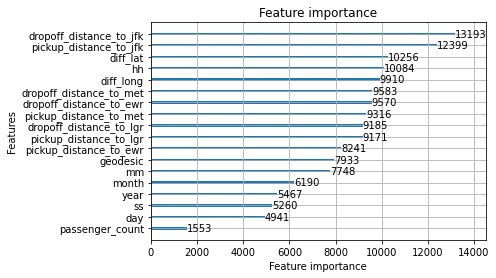

In [ ]:
lgbm.plot_importance(lgbm_bst,title='Feature importance', xlabel='Feature importance', ylabel='Features')

# XGBoost

### GPU boosted 

In [10]:
!nvidia-smi

Sun May 30 10:52:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
xgb_params = {
    'min_child_weight': 1, 
    'tree_method': 'gpu_hist',
    'colsample_bytree': 0.7, 
    'max_depth': 15,
    'subsample': 0.7,
    'n_estimators': 5000,
    'n_jobs': -1, 
    'booster' : 'gbtree', 
    'silent': 1,
    'eval_metric': 'rmse'}

In [12]:
def XGBmodel(X_train,X_test,y_train,y_test,params):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    model = xgb.train(params, dtrain, 1000, watchlist,early_stopping_rounds=50, maximize=False, verbose_eval=200)
    return model


### Random split

In [13]:
model = XGBmodel(X_train,X_test,y_train,y_test,xgb_params)

[0]	train-rmse:11.0413	valid-rmse:11.0548
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[30]	train-rmse:2.22316	valid-rmse:3.06653



In [14]:
filename="/content/drive/MyDrive/NYC/XGBregressorgpurandom.sav"
# to save the model
pickle.dump(model, open(filename, 'wb'))

### Year split

In [ ]:
model = XGBmodel(X_train,X_test,y_train,y_test,xgb_params)

[0]	train-rmse:9.99741	valid-rmse:10.0185
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[32]	train-rmse:2.22434	valid-rmse:2.88754



In [ ]:
filename="/content/drive/MyDrive/NYC/XGBregressor_gpu.sav"
# to save the model
pickle.dump(model, open(filename, 'wb'))

### CPU boosted

In [20]:
xgb_params = {
    'min_child_weight': 1, 
    'tree_method': 'hist',
    'colsample_bytree': 0.7, 
    'max_depth': 15,
    'subsample': 0.7,
    'n_estimators': 5000,
    'n_jobs': -1, 
    'booster' : 'gbtree', 
    'silent': 1,
    'eval_metric': 'rmse'}

In [21]:
def XGBmodel(X_train,X_test,y_train,y_test,params):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    model = xgb.train(params, dtrain, 1000, watchlist,early_stopping_rounds=50, maximize=False, verbose_eval=200)
    return model


#### Random split

In [22]:
model = XGBmodel(X_train,X_test,y_train,y_test,xgb_params)

[0]	train-rmse:11.0351	valid-rmse:11.045
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[26]	train-rmse:2.2633	valid-rmse:3.07096



### Year split

In [ ]:
model = XGBmodel(X_train,X_test,y_train,y_test,xgb_params)

[0]	train-rmse:9.99741	valid-rmse:10.0185
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[32]	train-rmse:2.22434	valid-rmse:2.88754



In [ ]:
filename="/content/drive/MyDrive/NYC/XGBregressor_gpu.sav"
# to save the model
pickle.dump(model, open(filename, 'wb'))

In [ ]:
print("Done")

Done


# Deep Learning

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5600000 entries, 12018707 to 11429533
Data columns (total 24 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   pickup_longitude         float32
 1   pickup_latitude          float32
 2   dropoff_longitude        float32
 3   dropoff_latitude         float32
 4   passenger_count          uint8  
 5   diff_lat                 float32
 6   diff_long                float32
 7   geodesic                 float32
 8   pickup_distance_to_jfk   float32
 9   dropoff_distance_to_jfk  float32
 10  pickup_distance_to_ewr   float32
 11  dropoff_distance_to_ewr  float32
 12  pickup_distance_to_lgr   float32
 13  dropoff_distance_to_lgr  float32
 14  pickup_distance_to_tsq   float32
 15  dropoff_distance_to_tsq  float32
 16  pickup_distance_to_met   float32
 17  dropoff_distance_to_met  float32
 18  day                      uint8  
 19  month                    uint8  
 20  year                     uint32 
 21  

In [17]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)
        
    def forward(self, x):
        y_pred = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(y_pred).clamp(min=0)
        y_pred = self.linear3(y_pred).clamp(min=0)
        y_pred = self.linear4(y_pred)
        return y_pred


In [18]:
H1, H2, H3 = 500, 1000, 200

In [19]:
xx=torch.tensor(X_train.values)

In [20]:
yy=torch.tensor(y_train.values)

In [21]:
yy.shape

torch.Size([5600000])

In [22]:
yy=torch.unsqueeze(yy, 1)

In [23]:
D_in, D_out = xx.shape[1], yy.shape[1]

In [24]:
D_out

1

In [25]:
criterion = nn.MSELoss(reduction='sum')



In [26]:
model1 = Net(D_in, H1, H2, H3, D_out)

In [ ]:
losses1 = []

for t in range(500):
    y_pred = model1(xx)
    
    loss = criterion(y_pred,yy)
    print(t, loss.item())
    losses1.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

# def baseline_model():
#     # create model
#     model = Sequential()
#     model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))
#     model.add(Dense(1, kernel_initializer='normal'))
#     # Compile model
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model
    
# seed = 7
# np.random.seed(seed)
# # evaluate model with standardized dataset
# estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)
# kfold = KFold(n_splits=10, random_state=seed)
# results = cross_val_score(estimator, X.values, y.values, cv=kfold, n_jobs=1)
# print("RMSE:", np.sqrt(results.std()))